In [ ]:
!rm -rf cv-image-classification
!git clone https://github.com/AlexFerroni02/cv-image-classification.git

Cloning into 'cv-image-classification'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 35 (delta 9), reused 28 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 3.92 MiB | 14.93 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [ ]:
import sys
sys.path.append("/content/cv-image-classification")

# Grad-CAM — Model Interpretability

This notebook applies Grad-CAM (Gradient-weighted Class Activation Mapping)
to visualize which regions of an image contribute most to the CNN's predictions.

The goals are:
- Interpret model decisions
- Detect spurious correlations
- Compare correct vs incorrect predictions
- Assess whether the model focuses on meaningful object regions


In [ ]:
import sys
sys.path.append("/content/cv-foundations")

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt


In [ ]:
from src.model import RegularizedCNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RegularizedCNN(num_classes=10).to(device)
model.load_state_dict(
    torch.load("/content/cv-image-classification/results/regularized_model.pth", map_location=device)
)
model.eval()


RegularizedCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [ ]:
transform = transforms.ToTensor()

test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

class_names = test_dataset.classes


100%|██████████| 170M/170M [00:03<00:00, 44.7MB/s]


In [ ]:
def show_image(img, title=None):
    img = img.permute(1, 2, 0).numpy()
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()


In [ ]:
class GradCAM:
    """
    Grad-CAM implementation for CNN-based classifiers.
    """

    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.activations = None
        self.gradients = None

        self._register_hooks()

    def _register_hooks(self):
        """
        Register forward and backward hooks to capture
        activations and gradients from the target layer.
        """

        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        """
        Generate Grad-CAM heatmap for a given input image.
        """

        # Forward pass
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        # Backward pass
        self.model.zero_grad()
        score = output[0, class_idx]
        score.backward()

        # Global average pooling of gradients
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)

        # Weighted combination of activations
        cam = (weights * self.activations).sum(dim=1)

        # Apply ReLU
        cam = F.relu(cam)

        # Normalize to [0, 1]
        cam -= cam.min()
        cam /= cam.max() + 1e-8

        return cam.squeeze().cpu().numpy(), class_idx


In [ ]:
# Use the last convolutional layer
target_layer = model.features[-2]  # Last Conv2d layer
gradcam = GradCAM(model, target_layer)


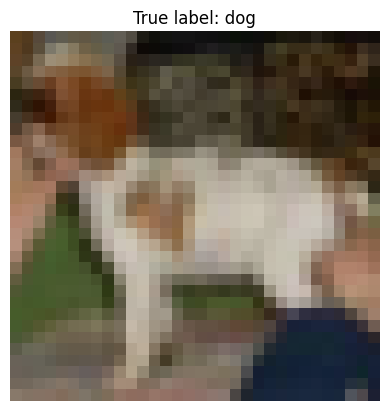

In [ ]:
idx = 12  # Try changing this index

image, label = test_dataset[idx]
input_tensor = image.unsqueeze(0).to(device)

show_image(image, title=f"True label: {class_names[label]}")


In [ ]:
cam, predicted_class = gradcam.generate(input_tensor)

print("Predicted class:", class_names[predicted_class])


Predicted class: frog


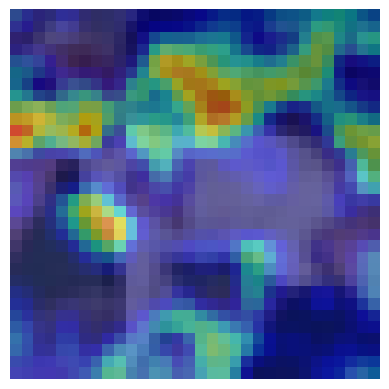

In [ ]:
def overlay_cam(image, cam):
    # Convert image tensor to numpy array (H, W, C)
    img_np = image.permute(1, 2, 0).numpy() # Shape: (32, 32, 3)

    # Resize cam (heatmap) to match the spatial dimensions of the image
    # cam is (16, 16) numpy array.
    # We convert it to a torch tensor, add batch and channel dimensions (1, 1, H_cam, W_cam),
    # interpolate to (1, 1, H_img, W_img), then remove the extra dimensions and convert back to numpy.
    cam_tensor = torch.from_numpy(cam).unsqueeze(0).unsqueeze(0) # (1, 1, H_cam, W_cam)
    cam_resized_tensor = F.interpolate(cam_tensor, size=(img_np.shape[0], img_np.shape[1]), mode='bilinear', align_corners=False)
    cam_resized_np = cam_resized_tensor.squeeze().numpy() # Shape: (H_img, W_img) which is (32, 32)

    # Generate heatmap from the resized CAM
    heatmap = plt.cm.jet(cam_resized_np)[..., :3] # Shape: (32, 32, 3)

    # Overlay the heatmap on the original image
    overlay = 0.5 * img_np + 0.5 * heatmap
    overlay = np.clip(overlay, 0, 1)

    plt.imshow(overlay)
    plt.axis("off")
    plt.show()

overlay_cam(image, cam)

## Grad-CAM Interpretation

The heatmap highlights the regions that most influenced the model's prediction.

Key observations:
- Ideally, attention should focus on the object itself
- Excessive focus on background indicates shortcut learning
- Distributed attention may suggest weak feature localization


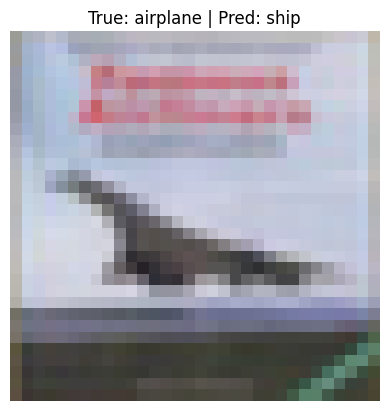

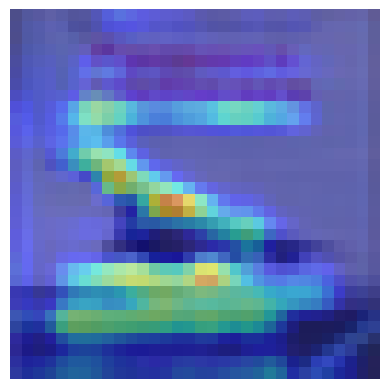

In [ ]:
# Find one misclassified example
for i in range(len(test_dataset)):
    img, lbl = test_dataset[i]
    inp = img.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(inp).argmax(1).item()

    if pred != lbl:
        break

show_image(img, title=f"True: {class_names[lbl]} | Pred: {class_names[pred]}")
cam, _ = gradcam.generate(inp)
overlay_cam(img, cam)


Found 5 misclassified examples (up to 5).


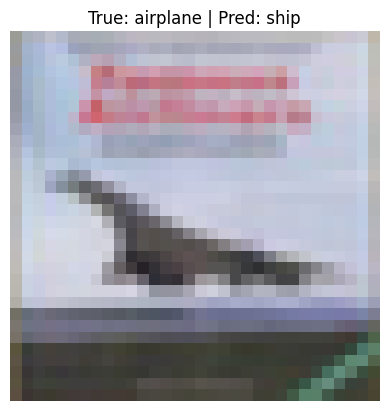

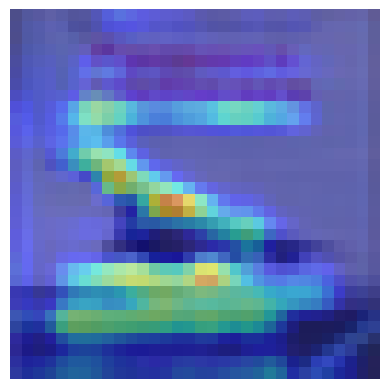

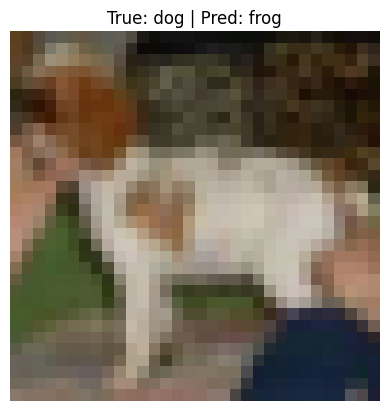

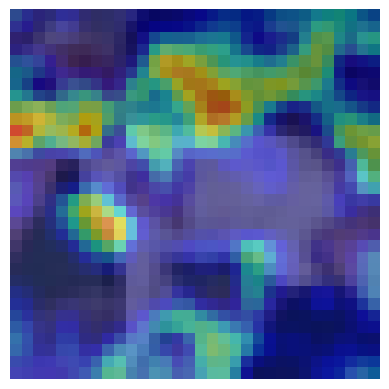

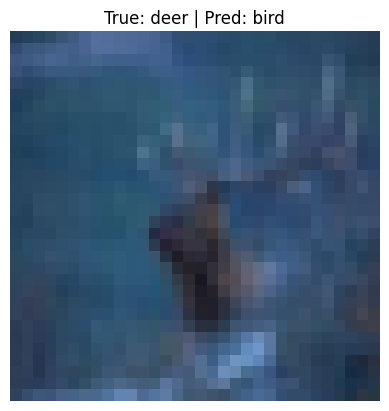

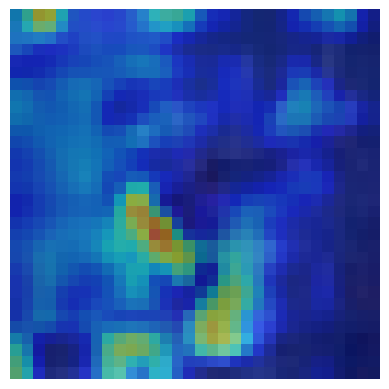

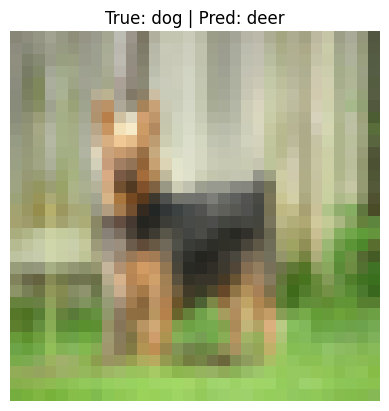

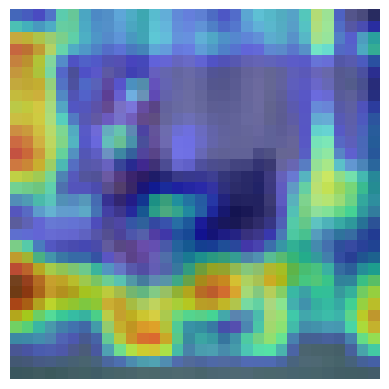

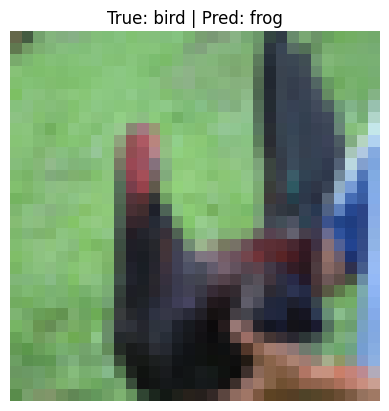

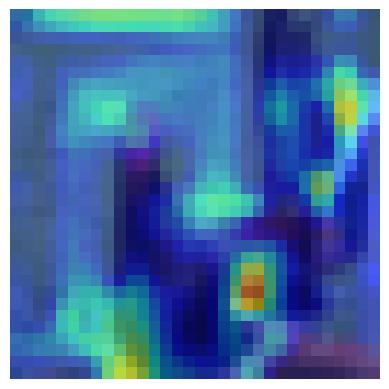

In [ ]:
misclassified_examples = []
count_misclassified = 0
max_misclassified_to_show = 5

for i in range(len(test_dataset)):
    if count_misclassified >= max_misclassified_to_show:
        break

    img, lbl = test_dataset[i]
    inp = img.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(inp).argmax(1).item()

    if pred != lbl:
        misclassified_examples.append((img, lbl, pred))
        count_misclassified += 1

print(f"Found {len(misclassified_examples)} misclassified examples (up to {max_misclassified_to_show}).")

# Display the collected misclassified examples with Grad-CAM
for img, lbl, pred in misclassified_examples:
    show_image(img, title=f"True: {class_names[lbl]} | Pred: {class_names[pred]}")

    inp_for_cam = img.unsqueeze(0).to(device)
    cam, _ = gradcam.generate(inp_for_cam)

    overlay_cam(img, cam)


## Error Analysis with Grad-CAM

For misclassified samples, Grad-CAM often reveals that:
- The model attends to irrelevant background regions
- Only partial object features are captured
- Small or occluded objects are ignored

These insights help explain failure modes that are not visible
through metrics alone.


## Conclusions

Grad-CAM provides valuable insight into the internal reasoning of the CNN.

From this analysis:
- The model generally focuses on meaningful object regions
- Failure cases correlate with poor spatial attention
- Regularization improves attention localization

Grad-CAM complements quantitative metrics and is an essential tool
for debugging and trusting deep learning models.
